### Author: `Winston Menzies`
> #### Imperial College Business School
> #### Professional Certificate in Machine Learning and Artifical Intelligence
#### Date: `18 January 2024`
#### Student ID: `484 (Class of 23-09)`
#### Function: `Load Capstone Results`
#### Usage: \<TODO\>

In [1]:
import os, time
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
from tabulate import tabulate
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
np.set_printoptions(threshold=np.inf)

#### - declare constant values

In [2]:
INITIAL_DATA_PATH = './initial_data/'
INITIAL_FILENAME_INPUTS = 'initial_inputs.npy'
INITIAL_FILENAME_OUTPUTS = 'initial_outputs.npy'
IMAGE_DIRECTORY = './docs/images/'
UPDATE_DATA_PATH = '/update_data/'
UPDATE_FILENAME_INPUTS = 'update_inputs.npy'
UPDATE_FILENAME_OUTPUTS = 'update_outputs.npy'
FUNCTION_DIRECTORY = 'function_'
DATA_PATH = './data/'
DATA_DIR_PREFIX = 'week_'
DATA_STUDENT_ID_SEPARATOR1 = '-'
DATA_STUDENT_ID_SEPARATOR2 = '_'
DATA_TYPE_OBSERVATIONS = 'observations'
DATA_TYPE_QUERIES = 'queries'
DATA_FILENAME = 'capstone_results.csv'
LARGEST_FUNCTION_DIMENSION = 8
TOTAL_FUNCTIONS = 8
INDEX_STUDENT_FILE = 1
INDEX_WEEK_NUM = 0
INDEX_STUDENT_ID = 0
INDEX_DATA_TYPE = 1
INDEX_DATA_FILENAME = 2
INDEX_FUNCTION_NUMBER = 2
INDEX_FUNCTION_VALUE = 3
INDEX_INPUT_VALUE = 2
INDEX_OUTPUT_VALUE = TOTAL_FUNCTIONS + INDEX_FUNCTION_VALUE
TOTAL_COLUMNS = INDEX_OUTPUT_VALUE + 1
BLANK_VALUE = None
BLANK_SPACE = ' '*6

#### - define `class` to encapsulate and manage the loading process

In [3]:
class CapstoneResultLoader(object):
    """
    Load Capstone Results
    Collate students queries and observations
    """
    def __init__(self):
        self._file_list = [] #store result files
        self._data_observations = [] #store observations
        self._data_queries = [] #store queries
        self._data_results = [] #store queries + observations 
        self._data_header = ["Week", "Student", "Fn", 
                             "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", 
                             "Y"]
        self._initial_data = {} #store initial input and output values
        self._update_data = {} #store appended input and output values
        self.initialisation()
        
    def initialisation(self):
        self._load_data()
        self._load_data_result()
        self._format_data_result()
        self._load_initial_data()
        self.print_file_list()
        self.update_initial_function_data()

    def get_data_header(self):
        return self._data_header
        
    def get_data_observations(self):
        return self._data_observations
        
    def get_data_queries(self):
        return self._data_queries
        
    def get_data_results(self):
        return self._data_results
        
    def get_data_size(self):
        dim = self._data_results.shape
        print(f'Rows = \033[1;34m{dim[0]}\033[0m Cols = \033[1;34m{dim[1]}\033[0m')
        
    def get_file_list(self):
        return self._file_list
        
    def get_initial_function_data(self):
        return self._initial_data

    def get_student_list(self):
        list = []
        for i in range(len(self._data_queries)):
            student = self._data_queries[i][INDEX_STUDENT_FILE]
            if list.count(student) == 0:
                list.append(student)
        return list
        
    def get_update_function_data(self):
        return self._update_data

    def get_week_list(self):
        list = []
        for i in range(len(self._data_queries)):
            week = self._data_queries[i][INDEX_WEEK_NUM]
            if list.count(week) == 0:
                list.append(week)
        return list
        
    def convert_to_pandas(self):
        df = pd.DataFrame(self._data_results, columns=self._data_header)
        return df
        
    def plot_observations(self, student_id = None, function_number = None):
        if function_number is None:
            fig, ax = plt.subplots(TOTAL_FUNCTIONS, 1, figsize=(8, 6 * TOTAL_FUNCTIONS))
            for i in range(1, TOTAL_FUNCTIONS + 1):
                self._plot_update_observations(i, ax[i - 1], student_id)
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            self._plot_update_observations(function_number, ax, student_id)
        plt.show()
        
    def print_file_list(self):
        self._format_file_list()
        
    def print_initial_function_data(self):
        return self._format_initial_function_data(self._initial_data)

    def print_function_results(self, num):
        list = []
        for i in range(len(self._data_results)):
            result = self._data_results[i]
            if result[INDEX_FUNCTION_NUMBER] == num:
                list.append(self._data_results[i])
        self._print_table_results(list)
        
    def print_results(self, sort=False):
        self._print_table_results(self._data_results, sort)
        
    def print_student_results(self, num, sort=False):
        list = []
        for i in range(len(self._data_results)):
            result = self._data_results[i]
            if result[INDEX_STUDENT_FILE] == num:
                list.append(self._data_results[i])
        self._print_table_results(list, sort)
        
    def print_updated_data(self):
        return self._format_initial_function_data(self._update_data)

    def print_html_updated_data(self):
        return self._format_html_updated_data(self._update_data)

    def save_plot_observations(self):
        fig, ax = plt.subplots(TOTAL_FUNCTIONS, 1, figsize=(8, 6 * TOTAL_FUNCTIONS))
        for i in range(1, TOTAL_FUNCTIONS + 1):
            self._plot_update_observations(i, ax[i - 1], None)
        # plt.gcf().set_size_inches(8, 48)
        plt.savefig(self._formulate_filename('graph'), bbox_inches='tight')
        plt.show()
        plt.close()
        
    def save_results(self):
        df = self.convert_to_pandas()
        df.to_csv(self._formulate_filename('results'), index=False)
        print(f'The capstone results file \033[1;34m{DATA_FILENAME}\033[0m has successfully saved.') 
        
    def update_initial_function_data(self):
        self._append_function_results()
        self._save_updated_results()

    def _get_directory_folder(self, dir):
        list = []
        for path in pathlib.Path(dir).iterdir():
            if path.is_dir():
                pos = path.name.find(DATA_STUDENT_ID_SEPARATOR2)
                if pos == -1:
                   data_dir = path.name
                else:
                    data_dir = path.name[pos+1:pos+3]
                list.append([data_dir, path])
        # return sorted folders (by week no.) 
        return sorted(list, key=lambda x: x[0]) 

    def _get_function_results(self, num):
        inputs = []
        outputs = []
        for i in range(len(self._data_results)):
            result = self._data_results[i]
            if result[INDEX_FUNCTION_NUMBER] == num:
                values = []
                # get input values for function 
                for i in range(INDEX_FUNCTION_VALUE, INDEX_FUNCTION_VALUE + LARGEST_FUNCTION_DIMENSION):
                    if result[i] != BLANK_VALUE:
                        values.append(result[i])
                # append input values 
                inputs.append(values)
                # get output value for function and append as list 
                outputs.append(result[INDEX_OUTPUT_VALUE])
        return (np.array(inputs), np.array(outputs))

    def _get_function_initial_observations(self, function_number):
        if not self._initial_data:
            return None
        return self._initial_data[str(function_number)]['outputs']
        
    def _get_function_update_observations(self, function_number):
        if not self._update_data:
            return None
        return self._update_data[str(function_number)]['outputs']
        
    def _get_observation_week_number(self, function_number, observation):
        week_num = 0
        a = self._data_results
        result = a[np.where((a[:,INDEX_FUNCTION_NUMBER] == function_number) * 
                            (a[:,INDEX_OUTPUT_VALUE] == observation))]
        if len(result) > 0:
            return result[0][INDEX_WEEK_NUM]
        return week_num
        
    def _get_week_number_color(self, week_number):
        color = 'black'
        if week_number == 1:
            color = 'yellow'
        elif week_number == 2:
            color = 'lime'
        elif week_number == 3:
            color = 'dodgerblue'
        elif week_number == 4:
            color = 'lime'
        elif week_number == 5:
            color = 'cyan'
        elif week_number == 6:
            color = 'peru'
        elif week_number == 7:
            color = 'slategray'
        else:
            color = 'dodgerblue'
        return color
        
    def _append_function_results(self):
        self._update_data = {}
        for key, value in self._initial_data.items():
            inputs, outputs = self._get_function_results(int(key))
            self._update_data[key] = dict({
                "inputs" : np.vstack([value["inputs"], inputs]),
                "outputs" : np.hstack([value["outputs"], outputs])
            });

    def _check_student_observation(self, function_number, student_id, observation):
        if student_id is not None:
            a = self._data_results
            result = a[np.where((a[:,INDEX_FUNCTION_NUMBER] == function_number) * 
                                (a[:,INDEX_STUDENT_FILE] == student_id) * 
                                (a[:,INDEX_OUTPUT_VALUE] == observation))]
            if len(result) > 0:
                return True
        return False
        
    def _check_updated_data_loaded(self, dir):
        if not os.path.exists(dir):
            os.makedirs(dir)
        return dir
        
    def _create_updated_directory(self, dir):
        if not os.path.exists(dir):
            os.makedirs(dir)
        return dir
        
    def _formulate_filename(self, type):
        filename = ""
        if type == 'results':
            filename = DATA_FILENAME
        elif type == 'graph':
            now = datetime.now()
            filename = f'{IMAGE_DIRECTORY}graph_{datetime.now().strftime("%y%m%d_%H%M")}.jpg'
        return filename

    def _load_data(self):
        dirs = self._get_directory_folder(DATA_PATH)
        for dir in dirs:
            data_file = self._process_directory(dir[1])
            self._file_list.append([dir[0], data_file])
                
    def _load_data_observation(self, filename):
        f = open(filename, 'r')
        observations = []
        values = ""
        count = 0
        for line in f.readlines():
            observations.append(line.replace('\n', '').strip())
        f.close()
        # process last set of observations only
        # print(f'::_load_data_observation::{filename}\nlength = [{len(observations)}]\n{observations}\n')
        observations = observations[len(observations)-1]#[1:-1]
        data = np.fromstring(observations[1:-1], dtype=float, sep=',')
        return data
    
    def _load_data_query(self, filename):
        f = open(filename, 'r')
        queries = []
        values = ""
        count = 0
        for line in f.readlines():
            count +=1
            if count == 1:
                values = line.replace('\n', '').strip() #store first line of query values
            else:
                #check if new (first line) set of query values
                pos = line.find('[array([')
                if pos == -1:
                    values += line.replace('\n', '').strip() #add query values
                    # print(f'::_load_data_query::{filename} {count}\n{values}')
                else:
                    #save current set of query values
                    # print(f'::_load_data_query::{filename} {count}\n{values}')
                    queries.append(values)
                    #store new (first line) set of query values
                    values = line.replace('\n', '').strip() 
                    count = 1
        f.close()
        # process last set of queries only
        queries.append(values)
        values = queries[len(queries)-1][1:-1]
        # print(f'::_load_data_query::{filename}\n{values}\n')
        values = values.split("),")
        data = []
        for i in range(len(values)):
            open_bracket_pos = values[i].find('[')
            end_bracket_pos = values[i].find(']')
            query = values[i][open_bracket_pos+1:end_bracket_pos]
            data.append(np.fromstring(query, dtype=float, sep=','))
            # print(f'::_load_data_query::{filename}\n{i} {data}')
        return data
    
    def _load_data_result(self):
        query_len = 0
        for i in range(len(self._file_list)):
            for j in range(len(self._file_list[i][INDEX_STUDENT_FILE])):
                student_file = self._file_list[i][INDEX_STUDENT_FILE][j]
                if student_file[INDEX_DATA_TYPE] == DATA_TYPE_OBSERVATIONS:
                    self._data_observations.append(self._load_data_observation(student_file[INDEX_DATA_FILENAME]))
                else:
                    queries = self._load_data_query(student_file[INDEX_DATA_FILENAME])
                    if len(queries) > query_len:
                        query_len = len(queries)
                    self._data_queries.append([self._file_list[i][INDEX_WEEK_NUM], 
                                               student_file[INDEX_STUDENT_ID], 
                                               queries])

    def _load_initial_data(self):
        for path in pathlib.Path(INITIAL_DATA_PATH).iterdir():
            if path.is_dir():
                data_dir = path.name
                # set key to directory number (last character)
                self._initial_data[data_dir[-1]] = dict({
                    "inputs" : np.load(INITIAL_DATA_PATH + '/' + data_dir + '/' + INITIAL_FILENAME_INPUTS),
                    "outputs" : np.load(INITIAL_DATA_PATH + '/' + data_dir + '/' + INITIAL_FILENAME_OUTPUTS)
                });
        
    def _plot_update_observations(self, function_number, axis, student_id):
        initial_observations = self._get_function_initial_observations(function_number)
        update_observations = self._get_function_update_observations(function_number)
        total_initial_observations = len(initial_observations)
        total_observations = len(update_observations)
        total_student_id_points = 0
        initial_point_color = 'black'
        student_point_color = 'lime'
        student_id_color = 'fuchsia'
        student_id_points = []
        week_points = []
        colors = []
        point_size = 100
        week_list = self.get_week_list()
        for i in range(len(week_list)):
            week_points.append(0)
        # loop through all observations points
        for x in range(1, total_observations+1):
            y = update_observations[x-1]
            week_number = int(self._get_observation_week_number(function_number, y))
            point_size = 100
            if x-1 < total_initial_observations:
                # initial observations
                color = initial_point_color
                point_size = 60
            else:
                # student observations
                color = self._get_week_number_color(week_number)
                # only one point per student
                # check student point hasn't already been counted, for current week
                if (week_points[week_number - 1] == 0 and
                    self._check_student_observation(function_number, student_id, y)):
                    week_points[week_number - 1] +=1
                    color = student_id_color
                    total_student_id_points +=1
                    student_id_points.append((week_number, x, y))
                    point_size = 110
            colors.append(color)
            axis.scatter(x, y, s=point_size, color=color, edgecolor='black')
        # rescale y axis
        vmin = np.min(update_observations)
        vmax = np.max(update_observations)
        y_ticks = axis.get_yticks()
        lower_tick_value = y_ticks[0]
        upper_tick_value = y_ticks[len(y_ticks) - 1]
        tick_unit = y_ticks[1] - y_ticks[0]
        x_limits = axis.get_xlim()
        y_limits = axis.get_ylim()
        axis.set_ylim(vmin - (tick_unit * 0.5), vmax + (tick_unit * 0.5))
        axis.set_xlabel('Samples')
        axis.set_ylabel('Observations')
        axis.set_facecolor('b')
        # Shrink current axis by 20%
        box = axis.get_position()
        axis.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # label student id points
        for i in range(len(student_id_points)):
            week = student_id_points[i][0]
            x = student_id_points[i][1]
            y = student_id_points[i][2]
            axis.annotate(f'wk{int(week)}', color='white', fontsize=8,
                          xy=(x, y), xycoords='data', xytext=(-8.0, 7.0), 
                          textcoords='offset points')
        # Put a legend to the right of the current axis
        legend_elements = []
        # add key
        legend_elements.append(Line2D([0], [0], label=f'initial data ({total_initial_observations})',
                               color='w', markeredgecolor='black',
                               marker='o', markersize=10, markerfacecolor=initial_point_color))
        # add metrics
        # show min and max values for initial observations
        vmin = np.min(initial_observations)
        vmax = np.max(initial_observations)
        legend_elements.append(Line2D([0], [0], label=f'min value: {vmin:.4f}', color='w'))
        legend_elements.append(Line2D([0], [0], label=f'max value: {vmax:.4f}', color='w'))
        if total_student_id_points > 0:
            legend_elements.append(Line2D([0], [0], label=f'student {student_id}',
                                   color='w', markeredgecolor='black',
                                   marker='o', markersize=10, markerfacecolor=student_id_color))
        legend_elements.append(Line2D([0], [0], 
                               label=f'student data ({total_observations - total_initial_observations})', color='w'))
        # add student data key colors
        for i in range(len(week_points)):
            legend_elements.append(Line2D([0], [0], 
                                   label=f'student data wk{i+1}',
                                   color='w', markeredgecolor='black', 
                                   marker='o', markersize=10, markerfacecolor=self._get_week_number_color(i+1)))
        axis.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.014, 0.55))
        axis.set_title(f'Function {function_number}')
        
    def _print_table_results(self, list, sort=False):
        table = []
        if sort:
            list = sorted(list, key = lambda x: (x[2], x[0]))
        for i in range(len(list)):
            result = list[i]
            values = []
            for j in range(len(result)):
                if result[j] == BLANK_VALUE:
                    values.append(BLANK_SPACE)
                else:
                    if j > INDEX_FUNCTION_NUMBER:
                        values.append(f'{result[j]:9.4f}')
                    else:
                        values.append(result[j])
            table.append(values)
        print(tabulate(table, headers=self._data_header))
        
    def _process_directory(self, dir):
        list = []
        for file in pathlib.Path(dir).iterdir():
            if file.is_file():
                list.append(self._format_data_file(file))
        # sort list of result files by student_id and data_type
        return sorted(list, key=lambda x: (x[0], x[1]))

    def _format_initial_function_data(self, data):
        table = []
        headers = ["Fn", "Sample", 
                   "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", 
                   "Y"]
        for key, value in data.items():
            inputs = value["inputs"]
            outputs = value["outputs"]
            for i in range(len(inputs)): #process function inputs
                values = []
                #append function number
                values.append(key)
                #append sample number
                values.append(i+1)
                total = len(inputs[i])
                for j in range(total): #process input values
                    values.append(f'{inputs[i][j]:9.4f}')
                #append blank values (if required)
                for k in range(LARGEST_FUNCTION_DIMENSION - total):
                    values.append(BLANK_SPACE) 
                #append function input value, output value
                values.append(f'{outputs[i]}')
                table.append(values)
        print(tabulate(table, headers=headers))
        
    def _format_html_updated_data(self, data):
        html = []
        tab_space = ' '*4
        html.append('<table>\n')
        # create table heading
        html.append(f'{tab_space*1}<thead>\n')
        html.append(f'{tab_space*2}<tr>\n')
        html.append(f'{tab_space*3}<th scope="col">Fn</th>\n')
        html.append(f'{tab_space*3}<th scope="col">Sample</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X1</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X2</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X3</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X4</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X5</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X6</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X7</th>\n')
        html.append(f'{tab_space*3}<th scope="col">X8</th>\n')
        html.append(f'{tab_space*3}<th scope="col">Y</th>\n')
        html.append(f'{tab_space*2}</tr>\n')
        html.append(f'{tab_space*1}</thead>\n')
        html.append(f'{tab_space*1}<tbody>\n')
        for key, value in data.items():
            inputs = value["inputs"]
            outputs = value["outputs"]
            for i in range(len(inputs)): #process function inputs
                html.append(f'{tab_space*2}<tr>\n')
                #append function number
                html.append(f'{tab_space*3}<th scope="row">{key}</th>\n')
                #append sample number
                html.append(f'{tab_space*3}<td>{i+1}</td>\n')
                total = len(inputs[i])
                for j in range(total): #process input values
                    html.append(f'{tab_space*3}<td>{inputs[i][j]:6.4f}</td>\n')
                #append blank values (if required)
                for k in range(LARGEST_FUNCTION_DIMENSION - total):
                    html.append(f'{tab_space*3}<td>&nbsp;</td>\n')
                #append function input value, output value
                html.append(f'{tab_space*3}<td>{outputs[i]}</td>\n')
                html.append(f'{tab_space*2}</tr>\n')
        html.append(f'{tab_space*1}</tbody>\n')
        html.append('</table>')
        print(*html)
        
    def _format_data_result(self):
        self._data_results = np.full((len(self._data_queries) * TOTAL_FUNCTIONS, TOTAL_COLUMNS),
                                     fill_value = BLANK_VALUE)
        for i in range(len(self._data_queries)):
            queries = self._data_queries[i][INDEX_INPUT_VALUE]
            for function in range(len(queries)):
                values = queries[function]
                self._data_results[(i * TOTAL_FUNCTIONS) + function, INDEX_FUNCTION_NUMBER] = function + 1
                self._data_results[(i * TOTAL_FUNCTIONS) + function, INDEX_OUTPUT_VALUE] = self._data_observations[i][function]
                for k in range(len(values)):
                    self._data_results[(i * TOTAL_FUNCTIONS) + function, INDEX_WEEK_NUM] = self._data_queries[i][INDEX_WEEK_NUM]
                    self._data_results[(i * TOTAL_FUNCTIONS) + function, INDEX_WEEK_NUM+1] = self._data_queries[i][INDEX_WEEK_NUM+1]
                    self._data_results[(i * TOTAL_FUNCTIONS) + function, k + INDEX_FUNCTION_VALUE] = float(values[k])

    def _format_data_file(self, filename):
        student_id = ""
        data_type = ""
        pos = filename.name.find(DATA_STUDENT_ID_SEPARATOR1)
        if pos == -1:
            pos = filename.name.find(DATA_STUDENT_ID_SEPARATOR2)
            if pos != -1:
                student_id = int(filename.name[0:pos])
        else:
            student_id = int(filename.name[0:pos])
        pos = filename.name.find(DATA_TYPE_OBSERVATIONS)
        if pos != -1:
            data_type = DATA_TYPE_OBSERVATIONS
        else:
            data_type = DATA_TYPE_QUERIES
        return [student_id, data_type, filename]
        
    def _format_file_list(self):
        table = []
        total_weeks = 0
        total_files = 0
        for key, files in self._file_list:
            total_weeks +=1
            for i in range(len(files)):
                total_files +=1
                values = []
                #append week number
                values.append(key)
                values.append(files[i][2])
                table.append(values)
        headers = [f'Week ({total_weeks})', f'Filename ({total_files})']
        print(tabulate(table, headers=headers))
        print("\n")

    def _save_updated_results(self):
        print('Saving updated files...')
        data_dir = self._create_updated_directory(os.getcwd() + UPDATE_DATA_PATH)
        for key, value in self._update_data.items():
            function_dir_path = f'{UPDATE_DATA_PATH}{FUNCTION_DIRECTORY}{key}'
            function_dir = self._create_updated_directory(f'{data_dir}/{FUNCTION_DIRECTORY}{key}')
            input_file = f'{function_dir}/{UPDATE_FILENAME_INPUTS}'
            output_file = f'{function_dir}/{UPDATE_FILENAME_OUTPUTS}'
            np.save(input_file, value["inputs"])
            np.save(output_file, value["outputs"])
            print(f'{BLANK_SPACE}\033[1;34m.{function_dir_path}/{UPDATE_FILENAME_INPUTS}\033[0m')
            print(f'{BLANK_SPACE}\033[1;34m.{function_dir_path}/{UPDATE_FILENAME_OUTPUTS}\033[0m')



In [4]:
# create instance of Loader
loader = CapstoneResultLoader()

  Week (3)  Filename (40)
----------  ---------------------------------
        01  data\week_01\427_observations.txt
        01  data\week_01\427_queries.txt
        01  data\week_01\428-observations.txt
        01  data\week_01\428-queries.txt
        01  data\week_01\431_observations.txt
        01  data\week_01\431_queries.txt
        01  data\week_01\434_observations.txt
        01  data\week_01\434_queries.txt
        01  data\week_01\453_observations.txt
        01  data\week_01\453_queries.txt
        01  data\week_01\464_observations.txt
        01  data\week_01\464_queries.txt
        01  data\week_01\479-observations.txt
        01  data\week_01\479-queries.txt
        01  data\week_01\484-observations.txt
        01  data\week_01\484-queries.txt
        02  data\week_02\428-observations.txt
        02  data\week_02\428-queries.txt
        02  data\week_02\431_observations.txt
        02  data\week_02\431_queries.txt
        02  data\week_02\434_observations.txt
        02  

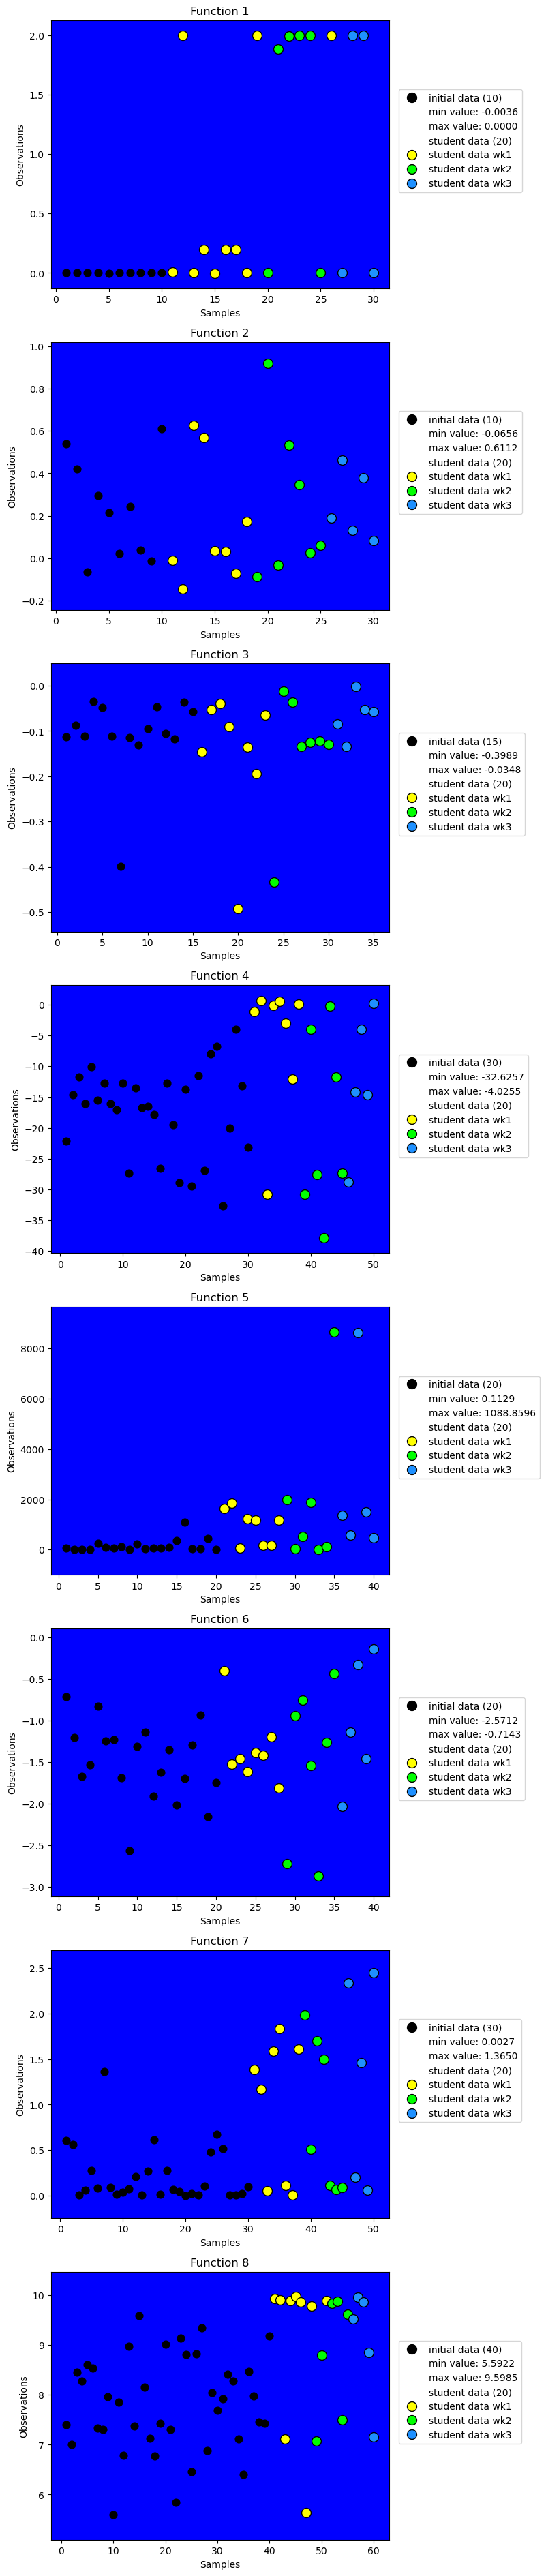

In [8]:
loader.save_plot_observations()